In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()



In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260210-2342_2q_qst


In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.11 00:40:30.880] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.11 00:40:30.882] INFO    VERSION: laboneq 25.10.3
[2026.02.11 00:40:30.883] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.11 00:40:30.927] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.11 00:40:30.966] INFO    Configuring the device setup
[2026.02.11 00:40:30.995] INFO    The device setup is configured


# amplitude rabi

In [ ]:
# from laboneq_applications.experiments import amplitude_rabi
# q = qubits[0]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)

# temporary_parameters[q.uid] = temp_pars

# #######################################################################
# amplitudes = np.linspace(0.0, 1.0,101)
# print(q.parameters.ge_drive_amplitude_pi)
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = amplitude_rabi.experiment_workflow.options()
# options.update(False)
# options.use_cal_traces(True)
# options.count(1024)
# #print(workflow.show_fields(options))

# ###################################################################
# rabi_amp = amplitude_rabi.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     amplitudes=amplitudes,
#     options=options,
#     temporary_parameters = temporary_parameters
# )

# rabi_amp_result = rabi_amp.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# print(rabi_amp_result.tasks['analysis_workflow'].output)

# Readout Opt

## Resonator Spectroscopy

In [ ]:
# from experiments import resonator_spectroscopy

# ####################################################################################
# q=qubits[1]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# #temp_pars.readout_resonator_frequency = 7.2370e9
# #temp_pars.readout_amplitude = 0.5
# temporary_parameters[q.uid] = temp_pars
# #temp_pars.readout_amplitude= 0.1
# print(q.readout_parameters())
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6,10e6,501)
# frequencies = temp_pars.readout_resonator_frequency + np.linspace(-3.0e6,3.0e6,501)
# #####################################################################################
# options = resonator_spectroscopy.experiment_workflow.options()
# #workflow.show_fields(options)
# options.count(1024)
# options.update(False)
# options.use_cw(False) #qop.measure 
# #options.fit_complex_resonator(False)
# #options.fit_lorentzian(True)
# ######################################################################################
# # Build and run resonator_spectroscopy_amplitude wormflow
# res_spec = resonator_spectroscopy.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubit=q,
#     frequencies=frequencies,
#     options=options,
#     temporary_parameters=temporary_parameters,
#     acquire_port_delay= 500e-9#1e-6
# )
# res_spec_result = res_spec.run()
# res_spec_analysis_result = res_spec_result.tasks["analysis_workflow"]
# pprint(res_spec_analysis_result.output)

In [ ]:
# from experiments import qubit_spectroscopy

# ###############################################################
# q = qubits[0]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temp_pars.spectroscopy_amplitude = 0.15 #0.006 #0.003
# temporary_parameters[q.uid] = temp_pars

# frequencies = temp_pars.resonance_frequency_ge+ np.linspace(-8e6, 8e6, 101)
# #print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# pprint(q.readout_parameters())
# pprint(q.spectroscopy_parameters())
# ################################################################
# options = qubit_spectroscopy.experiment_workflow.options()
# options.update(False)
# options.count(1024)
# # workflow.show_fields(options)
# ###################################################################
# qubit_spec = qubit_spectroscopy.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     frequencies=frequencies,
#     options=options,
#     temporary_parameters=temporary_parameters
# )

# qubit_spec_result = qubit_spec.run()
# qubit_spec_result

## Dispersive Shift

In [ ]:

# from experiments import dispersive_shift

# #######################################################################
# q = qubits[1]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)

# temp_pars.readout_amplitude = 0.7
# temporary_parameters[q.uid] = temp_pars

# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = dispersive_shift.experiment_workflow.options()
# options.count(1024)
# options.update(False)
# #print(workflow.show_fields(options))

# ###################################################################
# dispersive = dispersive_shift.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubit=q,
#     frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
#     options=options,
#     states='ge',
#     temporary_parameters=temporary_parameters
# )

# dispersive_result = dispersive.run() 
# print(dispersive_result.tasks['analysis_workflow'].output)

## IQ TRAJ

In [ ]:
# from experiments import iq_traj

# ####################################################################################
# q=qubits[1]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)

# temp_pars.readout_resonator_frequency = 7.5908e9
# temporary_parameters[q.uid] = temp_pars
# #######################################################################
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# pprint(q.readout_parameters())
# #######################################################################
# options = iq_traj.experiment_workflow.options()
# options.count(2**14)
# options.do_analysis(True)

# #print(workflow.show_fields(options))

# ###################################################################
# iq_t = iq_traj.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     options=options,
#     states='ge',
#     temporary_parameters=temporary_parameters
# )

# iq_traj_result = iq_t.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# iq_traj_result.tasks['analysis_workflow'].tasks['plot_iq_trajectories'].output[q.uid]

In [ ]:

# from experiments import iq_blobs

# #######################################################################
# q = qubits[1]

# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)

# temporary_parameters[q.uid] = temp_pars
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = iq_blobs.experiment_workflow.options()
# options.count(2**14)
# #print(workflow.show_fields(options))

# ###################################################################
# iq = iq_blobs.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     options=options,
#     states='ge',
#     temporary_parameters=temporary_parameters
# )
# iq_blob_result = iq.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# iq_blob_result.tasks['analysis_workflow'].tasks['plot_iq_blobs'].output[q.uid]
# print(iq_blob_result.tasks['analysis_workflow'].output)


# Qubit recalibration

`Ramsey` -> `pi & half pi` -> `RB`

In [ ]:
# qubits[0].parameters.readout_integration_length = 1.3e-6
# qubits[0].parameters.drive_lo_frequency = 4.4e9
# qubits[0].parameters.readout_lo_frequency = 7.4e9
# qubits[0].parameters.drive_range = 10
# qubits[0].parameters.readout_range_out = 0
# qubits[0].parameters.readout_range_in = 0
# qubits[0].parameters.readout_integration_delay = 500e-9
# qubits[0].parameters.readout_length = 1.3e-6

# qubits[1].parameters.readout_integration_length = 1.3e-6
# qubits[1].parameters.drive_lo_frequency = 4.4e9
# qubits[1].parameters.readout_lo_frequency = 7.4e9
# qubits[1].parameters.drive_range = 10
# qubits[1].parameters.readout_range_out = 0
# qubits[1].parameters.readout_range_in = 0
# qubits[1].parameters.readout_integration_delay = 500e-9
# qubits[1].parameters.readout_length = 1.3e-6

# buses[0].parameters.drive_lo_frequency = 5.8e9
# buses[0].parameters.drive_range = 10
# print(buses[0].parameters.resonance_frequency_bus)
# buses[0].parameters.rip_amplitude = 0.5
# buses[0].parameters.rip_detuning = 14e6


# buses[1].parameters.drive_lo_frequency = 5.8e9
# buses[1].parameters.drive_range = 10
# print(buses[1].parameters.resonance_frequency_bus)
# buses[1].parameters.rip_amplitude = 0.5
# buses[1].parameters.rip_detuning = -36e6




### Ramsey

In [ ]:
from laboneq_applications.experiments import ramsey

q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,20e-6,301)
detunings = 0.4e6 #4e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(False)
options.count(512)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
#ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q0']

### Amplitude Calibration

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#temp_pars.ge_drive_amplitude_pi =0.64
#######################################################################
repetitions =np.arange(1,12) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(False)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

# RB 

In [ ]:
#from laboneq_applications.experiments import 
from experiments import single_qubit_randomized_benchmarking
q = qubits[1]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

#############################################
options = single_qubit_randomized_benchmarking.experiment_workflow.options()
options.count(1024)
options.transition("ge")


rb = single_qubit_randomized_benchmarking.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    length_cliffords=[1,5,10,20,50],
    variations=50,
    options=options,
)

rb_result = rb.run()

#######################################################################

## 2Q QST Modules Overview

- `experiments.two_qubit_readout_calibration`: `|00>, |01>, |10>, |11>` 상태를 준비해 4x4 readout assignment matrix를 추정합니다.
- `experiments.two_qubit_state_tomography`: `ctrl/targ`를 `|+>`로 준비하고 bus에 고정 RIP를 적용한 뒤 9개 Pauli 설정(XX~ZZ)으로 측정합니다.
- `analysis.two_qubit_state_tomography`: assignment matrix를 포함한 noisy POVM + Cholesky MLE로 `rho`를 복원하고 metric/plot을 생성합니다.

아래 셀은 calibration -> tomography(+analysis) 순서로 실행하는 최소 예시입니다.

## 2Q Multiplexed IQ Blob Example

`experiments.multiplexed_iq_blobs` 모듈을 실행해 2Q multiplexed readout용 threshold/assignment를 추출하는 최소 예시입니다.


[2026.02.11 00:40:43.476] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 00:40:43.476] INFO      Workflow 'multiplexed_iq_blobs': execution started at 2026-02-10              
[2026.02.11 00:40:43.477] INFO      15:40:43.476267Z                                                              
[2026.02.11 00:40:43.477] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 00:40:43.485] INFO    Task 'temporary_qpu': started at 2026-02-10 15:40:43.485550Z
[2026.02.11 00:40:43.487] INFO    Task 'temporary_qpu': ended at 2026-02-10 15:40:43.486945Z
[2026.02.11 00:40:43.489] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-10 
[2026.02.11 00:40:43.489] INFO    15:40:43.489445Z
[2026.02.11 00:40:43.490] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-10 15:40:43.490420Z
[2026.02.11 00:40:43.491] INFO    Task 'temporary_quantum_elements_from_qpu': started

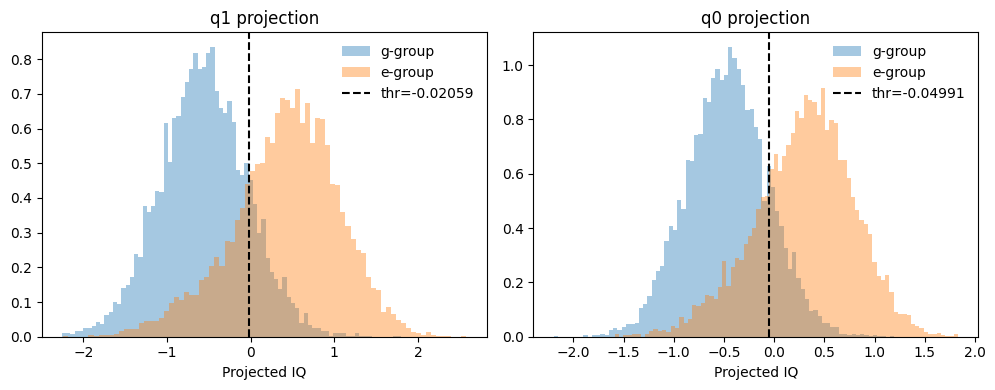

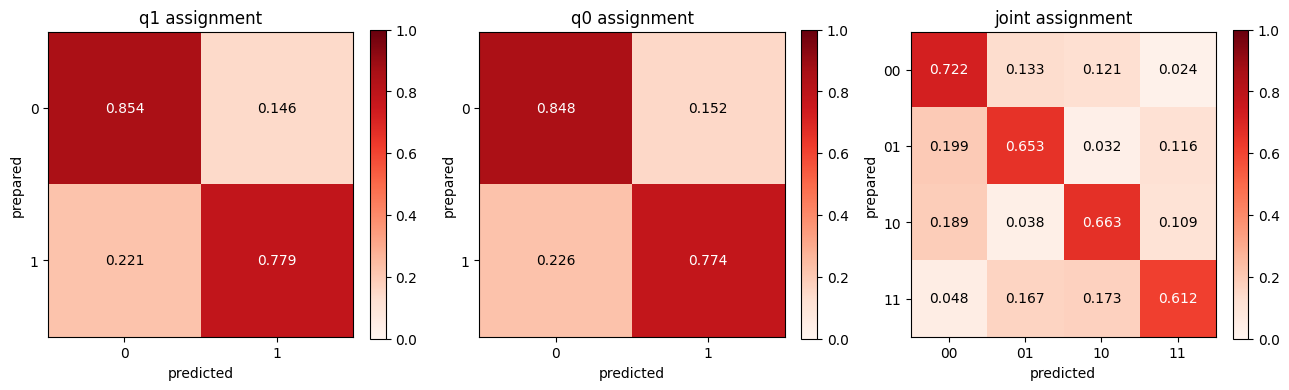

In [6]:
from experiments import multiplexed_iq_blobs

# 2Q multiplexed IQ blob run (threshold extraction)
ctrl = qubits[1]
targ = qubits[0]

mx_iq_options = multiplexed_iq_blobs.experiment_workflow.options()
mx_iq_options.do_analysis(True)

mx_iq_result = multiplexed_iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    options=mx_iq_options,
).run()

mx_payload = mx_iq_result.output
mx_analysis = mx_payload.get("analysis_result")
if hasattr(mx_analysis, "output"):
    mx_analysis = mx_analysis.output

print("ctrl threshold:", mx_analysis["thresholds"][ctrl.uid]["threshold"])
print("targ threshold:", mx_analysis["thresholds"][targ.uid]["threshold"])
print("joint fidelity:", mx_analysis["assignment"]["joint_fidelity"])


In [8]:
qubits[1].parameters.readout_integration_discrimination_thresholds

[-0.20377352278065042]

In [ ]:
from experiments import two_qubit_state_tomography
from experiments import two_qubit_readout_calibration
from analysis.two_qubit_state_tomography import infer_bitflip_from_readout_calibration

# 2Q QST example run (RIP fixed-parameter mode)
ctrl = qubits[1]
targ = qubits[0]
bus = buses[0]
temporary_parameters = {}
c_temp_pars = deepcopy(ctrl.parameters)
t_temp_pars = deepcopy(targ.parameters)
b_temp_pars = deepcopy(bus.parameters)

temporary_parameters[ctrl.uid] = c_temp_pars
temporary_parameters[targ.uid] = t_temp_pars
temporary_parameters[bus.uid] = b_temp_pars

# 외부 readout calibration 실행
readout_cal_result = two_qubit_readout_calibration.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    temporary_parameters=temporary_parameters,
).run()

# calibration 결과로 qubit별 bitflip 자동 진단
bitflip_info = infer_bitflip_from_readout_calibration(
    readout_calibration_result=readout_cal_result,
    ctrl_uid=ctrl.uid,
    targ_uid=targ.uid,
)
bitflip_ctrl_auto = bool(bitflip_info["bitflip_ctrl"])
bitflip_targ_auto = bool(bitflip_info["bitflip_targ"])
print("auto bitflip ctrl/targ:", bitflip_ctrl_auto, bitflip_targ_auto)
print("ctrl acc direct/flip:", bitflip_info["accuracy_ctrl_direct"], bitflip_info["accuracy_ctrl_flip"])
print("targ acc direct/flip:", bitflip_info["accuracy_targ_direct"], bitflip_info["accuracy_targ_flip"])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from experiments.two_qubit_tomography_common import (
    READOUT_CALIBRATION_STATES,
    OUTCOME_LABELS,
    readout_calibration_handle,
)

def _unwrap_result_like(x):
    cur = x
    for _ in range(8):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        if isinstance(cur, dict):
            if "readout_calibration_result" in cur:
                cur = cur["readout_calibration_result"]
                continue
        return cur
    return cur

def _to_bits(arr):
    arr = np.asarray(arr).reshape(-1)
    return np.clip(np.rint(np.real(arr)).astype(int), 0, 1)

def build_assignment_matrix(readout_result, ctrl_uid, targ_uid, bitflip_ctrl=False, bitflip_targ=False):
    res = _unwrap_result_like(readout_result)
    counts = np.zeros((4, 4), dtype=int)  # rows: measured i, cols: prepared k

    for k, (prep_label, _states) in enumerate(READOUT_CALIBRATION_STATES):
        ctrl_bits = _to_bits(res[readout_calibration_handle(ctrl_uid, prep_label)].data)
        targ_bits = _to_bits(res[readout_calibration_handle(targ_uid, prep_label)].data)
        if bitflip_ctrl:
            ctrl_bits = 1 - ctrl_bits
        if bitflip_targ:
            targ_bits = 1 - targ_bits
        outcomes = 2 * ctrl_bits + targ_bits  # 00,01,10,11 -> 0,1,2,3
        counts[:, k] = np.bincount(outcomes, minlength=4)

    A = counts / np.maximum(counts.sum(axis=0, keepdims=True), 1)
    return A, counts

bitflip_ctrl = bool(globals().get("bitflip_ctrl_auto", False))
bitflip_targ = bool(globals().get("bitflip_targ_auto", False))

A_raw, C_raw = build_assignment_matrix(readout_cal_result, ctrl.uid, targ.uid, False, False)
A_fix, C_fix = build_assignment_matrix(readout_cal_result, ctrl.uid, targ.uid, bitflip_ctrl, bitflip_targ)

fid_raw = float(np.trace(A_raw) / 4.0)
fid_fix = float(np.trace(A_fix) / 4.0)
print("bitflip applied ctrl/targ:", bitflip_ctrl, bitflip_targ)
print(f"fidelity raw={fid_raw:.4f}, fixed={fid_fix:.4f}")

A = A_fix
C = C_fix
print("\nAssignment matrix A (bitflip-adjusted) (rows=measured, cols=prepared):")
print(np.array_str(A, precision=4, suppress_small=True))
print("Column sums (should be 1):", A.sum(axis=0))
print("Diagonal assignment probs:", np.diag(A))
print("Average assignment fidelity:", np.trace(A) / 4.0)
print("Shots per prepared state:", C.sum(axis=0))

assert np.allclose(A.sum(axis=0), 1.0, atol=1e-6), "Column sums are not ~1"

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for ax, mat, title in [
    (axes[0], A_raw, "Raw assignment"),
    (axes[1], A_fix, f"Bitflip-adjusted (ctrl={bitflip_ctrl}, targ={bitflip_targ})"),
]:
    im = ax.imshow(mat, vmin=0, vmax=1, cmap="Reds")
    ax.set_title(title)
    ax.set_xlabel("Prepared state k")
    ax.set_ylabel("Measured state i")
    ax.set_xticks(range(4), OUTCOME_LABELS)
    ax.set_yticks(range(4), OUTCOME_LABELS)
    for i in range(4):
        for j in range(4):
            ax.text(j, i, f"{mat[i,j]:.3f}", ha="center", va="center",
                    color="white" if mat[i,j] > 0.6 else "black")

fig.colorbar(im, ax=axes.ravel().tolist(), label="P(measured=i | prepared=k)")
plt.suptitle(f"2Q Assignment Matrix: raw={fid_raw:.4f}, fixed={fid_fix:.4f}")
plt.show()


In [ ]:
from experiments import two_qubit_state_tomography

tomo_options = two_qubit_state_tomography.experiment_workflow.options()
tomo_options.do_analysis(True)
tomo_options.do_readout_calibration(False)  # 외부 readout_cal_result 사용
tomo_options.auto_bitflip_from_calibration(True)  # calibration 결과로 ctrl/targ bitflip 자동 추정
# 수동 강제값을 쓰려면 아래처럼 설정하고 auto_bitflip_from_calibration(False)로 변경
# tomo_options.bitflip_ctrl(True)
# tomo_options.bitflip_targ(False)

bus_frequency = (
    bus.parameters.resonance_frequency_bus + (bus.parameters.rip_detuning or 0.0)
    if bus.parameters.resonance_frequency_bus is not None
    else 6.5e9
)
rip_amplitude = 0.0 #float(bus.parameters.rip_amplitude)
rip_length = 64e-9 #float(bus.parameters.rip_length)

twoq_qst_result = two_qubit_state_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    bus=bus,
    bus_frequency=bus_frequency,
    rip_amplitude=rip_amplitude,
    rip_length=rip_length,
    rip_phase=np.pi / 2,
    readout_calibration_result=readout_cal_result,
    target_state="++",
    options=tomo_options,
    temporary_parameters=temporary_parameters,
).run()

workflow_output = twoq_qst_result.output
analysis_output = workflow_output.get("analysis_result")
if hasattr(analysis_output, "output"):
    analysis_output = analysis_output.output

print("workflow keys:", list(workflow_output.keys()))
if isinstance(analysis_output, dict):
    print("analysis keys:", list(analysis_output.keys()))
    print("applied bitflip ctrl/targ:", analysis_output.get("bitflip_ctrl"), analysis_output.get("bitflip_targ"))
    print("metrics:")
    pprint(analysis_output.get("metrics", {}))


In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=twoq_qst_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)
#plot_simulation(compiled_experiment=co_spec_result.tasks["compile_experiment"].output, length=250e-6)

# SAVE QPU

In [ ]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "2q_qst"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")



## 2Q QST Guideline Compliance (STEP-by-STEP)

아래는 `examples/selectiveRIP/2Q_quantum_state_tomography.md` 지침과 현재 구현 코드의 매핑입니다.

**STEP 1. 9개 측정 설정 $s$**

수식/개념:
$$
s \in \{XX,XY,XZ,YX,YY,YZ,ZX,ZY,ZZ\}
$$

코드:
- `experiments/two_qubit_tomography_common.py`의 `TOMOGRAPHY_SETTINGS`
- `experiments/two_qubit_state_tomography.py:create_experiment()` 루프에서 각 setting 실행
- basis pre-rotation은 `_apply_measurement_prerotation()`로 구현

**STEP 2. Assignment matrix $A_{ik}$ calibration**

수식:
$$
A_{ik}=\frac{c_i^{(k)}}{N^{(k)}},\qquad N^{(k)}=\sum_i c_i^{(k)}
$$

코드:
- 실험: `experiments/two_qubit_readout_calibration.py:create_experiment()`
  - 준비 상태: $|00\rangle,|01\rangle,|10\rangle,|11\rangle$
- 분석: `analysis/two_qubit_state_tomography.py:extract_assignment_matrix()`
  - `counts_matrix[:,k] / sum(counts_matrix[:,k])`

**STEP 3. Ideal POVM $E^{ideal}_{s,k}$**

수식:
$$
E^{\mathrm{ideal}}_{s,k}=U_s^\dagger\Pi_k U_s
$$

코드:
- `analysis/two_qubit_state_tomography.py:_computational_projectors_2q()`
- `analysis/two_qubit_state_tomography.py:_single_qubit_prerotation_unitary()`
- `analysis/two_qubit_state_tomography.py:_build_noisy_povm()` 내부에서 `ideal_povm` 생성

**STEP 4. Noisy POVM $E^{meas}_{s,i}$**

수식:
$$
E^{\mathrm{meas}}_{s,i}=\sum_k A_{ik}E^{\mathrm{ideal}}_{s,k}
$$

코드:
- `analysis/two_qubit_state_tomography.py:_build_noisy_povm()`
  - `e_meas += assignment_matrix[i,k] * ideal_povm[k]`

**STEP 5. 확률 모델 $p_{s,i}(\rho)$**

수식:
$$
p_{s,i}(\rho)=\mathrm{Tr}\left(E^{\mathrm{meas}}_{s,i}\rho\right)
$$

코드:
- `analysis/two_qubit_state_tomography.py:_predict_probabilities()`

**STEP 6. 로그우도 최대화(MLE)**

수식:
$$
\log L(\rho)=\sum_{s,i} n_{s,i}\log p_{s,i}(\rho),\qquad
\min -\log L
$$

코드:
- `analysis/two_qubit_state_tomography.py:maximum_likelihood_reconstruct()`
- objective: `-np.sum(counts * np.log(probs))`

**STEP 7. 물리적 상태 파라미터화(Cholesky)**

수식:
$$
\rho(\theta)=\frac{T(\theta)^\dagger T(\theta)}{\mathrm{Tr}(T(\theta)^\dagger T(\theta))}
$$

코드:
- `analysis/two_qubit_state_tomography.py:_theta_to_density_matrix()`
  - lower-triangular 복소 행렬 `T` 구성 후 `T^\dagger T` 정규화

**STEP 8. 검증/후처리**

코드:
- `analysis/two_qubit_state_tomography.py:calculate_state_metrics()`
  - trace, purity, min eigenvalue, Pauli correlators, target fidelity
- `plot_density_matrix()`, `plot_counts()`

**실험 시퀀스(요청사항 반영) 정합성**

현재 `experiments/two_qubit_state_tomography.py`에서 각 setting마다 순서가 아래처럼 강제됩니다:
$$
\text{prep} \rightarrow \text{RIP} \rightarrow \text{basis rotation} \rightarrow \text{measure}
$$

`play_after` 체인으로 겹침을 막도록 구현되어 있습니다.

**참고(지침 대비 구현 선택)**

- readout은 `AcquisitionType.DISCRIMINATION`을 사용해 bit outcome을 직접 수집하고, 이를 count $n_{s,i}$로 변환합니다.
- 기본 shot 수는 현재 설정상 4096(지침 예시 5k~20k보다 낮음)이며, 옵션으로 늘릴 수 있습니다.
